# converted to MongoDB

In [4]:
from pymongo import MongoClient
from collections import Counter

# Connect to your MongoDB instance
client = MongoClient('mongodb://localhost:27017/')
db = client['vaers']  # Replace 'your_database' with your actual database name
collection = db['reports']  # Replace 'your_collection' with your actual collection name

# get most occuring vaccines

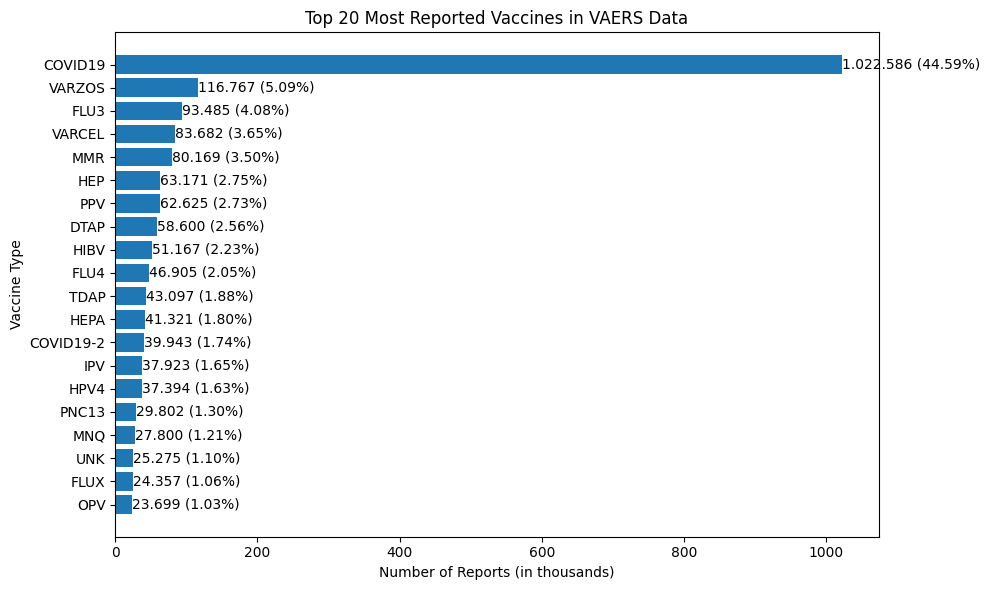

In [30]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import locale

# Set the locale to format numbers with thousands separator
locale.setlocale(locale.LC_ALL, '')

# MongoDB aggregation pipeline to count vaccine occurrences
pipeline = [
    {"$unwind": "$vax_data"},  # Unwind the vax_data array
    {"$group": {"_id": "$vax_data.VAX_TYPE", "count": {"$sum": 1}}},  # Group by VAX_TYPE and count occurrences
    {"$sort": {"count": -1}}  # Sort by count in descending order
]

# Execute the aggregation pipeline to get counts for all vaccines
all_vaccine_counts = collection.aggregate(pipeline)

# Extract vaccine types and counts for all vaccines
all_vaccine_counts_dict = {vaccine['_id']: vaccine['count'] for vaccine in all_vaccine_counts}

# MongoDB aggregation pipeline to count vaccine occurrences for the top 20 most reported vaccines
pipeline_top_20 = pipeline + [{"$limit": 20}] 

# Execute the aggregation pipeline to get counts for the top 20 most reported vaccines
vaccine_counts = collection.aggregate(pipeline_top_20)

# Extract vaccine types and counts for the top 20 most reported vaccines
vaccine_types = []
vaccine_counts_list = []
for vaccine in vaccine_counts:
    vaccine_types.append(vaccine['_id'])
    vaccine_counts_list.append(vaccine['count'])

# Calculate total number of reports for all vaccines
total_reports_all_vaccines = sum(all_vaccine_counts_dict.values())

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(range(1, len(vaccine_types) + 1), vaccine_counts_list)
plt.yticks(range(1, len(vaccine_types) + 1), vaccine_types)  # Set y-tick labels

plt.title('Top 20 Most Reported Vaccines in VAERS Data')
plt.xlabel('Number of Reports (in thousands)')
plt.ylabel('Vaccine Type')

plt.gca().invert_yaxis()  # Invert y-axis to have the most frequent vaccine at the top

# Add numbers and percentages to the bars in thousands with a dot separator
for i, (count, vaccine_type) in enumerate(zip(vaccine_counts_list, vaccine_types)):
    formatted_count = locale.format_string('%.0f', count, grouping=True)
    formatted_count = formatted_count.replace(',', '.')  # Replace comma with dot
    percentage = (count / total_reports_all_vaccines) * 100
    plt.text(count, i + 1, f'{formatted_count} ({percentage:.2f}%)', va='center', ha='left')

# Define a function to format x-axis ticks in thousands
def format_thousands(x, pos):
    return '{:.0f}'.format(x * 1e-3)

# Apply the formatter to the x-axis
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))

plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Vaccines/Top20VaccinesWithPercentage.png')
plt.show()
